<a href="https://colab.research.google.com/github/HathawayQAQ/COMP551-Machine-Learning/blob/main/Assignment1/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statement

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

# Task 1: Acquire, preprocess, and analyze the data
## Data Preperation
1. Dataset1: Infrared Thermography Temperature (regression): [link](https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset)
2. Dataset 2: CDC Diabetes Health Indicators (classification): [link](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators)

## Acquire

In [ ]:
# Dataset 1
infrared_thermography_temperature = fetch_ucirepo(id=925)
X = infrared_thermography_temperature.data.features
y = infrared_thermography_temperature.data.targets

# Dataset 2
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X2 = cdc_diabetes_health_indicators.data.features
y2 = cdc_diabetes_health_indicators.data.targets

## Preprocess

Dataset 1 preprocessed cell

In [ ]:
# Handle missing values
nan_rows = X.isnull().any(axis=1)
X_clean = X[~nan_rows]
y_clean = y[~nan_rows]

# Handle categorical features
categorical_columns = ['Age', 'Gender', 'Ethnicity']
X_dummies = pd.get_dummies(X_clean, columns=categorical_columns, drop_first=True)

# Convert boolean columns to integer
bool_columns = X_dummies.select_dtypes(include=['bool']).columns
for col in bool_columns:
    X_dummies[col] = X_dummies[col].astype(int)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

# Select the target variable
y_final = y_clean['aveOralM']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_final, test_size=0.2, random_state=42)

Dataset 2 preprocessed cell

In [ ]:
X2_af, y2_af = X2.values, y2.values
y2 = y2_af.reshape(-1)

# Scale features
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2_af)

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.6, random_state=42)

print(X2_train.shape)
print(y2_train.shape)

(101472, 21)
(101472,)


Linear Regression Model

In [ ]:
class LinearRegressionModel:
    def __init__(self):
        self.weights = None

    def fit(self, features, target):
        num_samples, num_features = features.shape
        features_with_bias = np.column_stack([np.ones(num_samples), features])  # Added bias term (ones)
        self.weights, loss = self.calculate_least_squares_loss(features_with_bias, target)
        return (loss, self.weights)

    def calculate_least_squares_loss(self, features, target):
        weights = np.linalg.inv(features.T @ features) @ features.T @ target
        loss = np.mean((target - features @ weights) ** 2)
        return weights, loss

    def predict(self, features):
        features_with_bias = np.column_stack([np.ones(features.shape[0]), features])  # Added bias term (ones)
        return features_with_bias @ self.weights

In [ ]:
class LinearRegressionSGD:
    def __init__(self):
        self.weights = None

    def fit(self, features, target, max_iterations=1000, tolerance=1e-5, learning_rate=1e-2, verbose=False, batch_size=16):
        # Ensure features and target have the same index
        if isinstance(features, pd.DataFrame) and isinstance(target, pd.Series):
            features, target = features.align(target, join='inner', axis=0)

        # Convert to numpy arrays
        if isinstance(features, pd.DataFrame):
            features = features.values
        if isinstance(target, pd.Series):
            target = target.values

        num_samples, num_features = features.shape

        # Add bias term
        features_with_bias = np.column_stack([np.ones(num_samples), features])

        # Initialize weights if not already set
        if self.weights is None:
            self.weights = 0.001 * np.random.randn(features_with_bias.shape[1])

        # Set up random number generator
        rng = np.random.default_rng()
        previous_loss = float('inf')

        for iteration in range(max_iterations):
            # Randomly sample a batch of data
            batch_indices = rng.choice(num_samples, batch_size, replace=False)
            features_batch = features_with_bias[batch_indices, :]
            target_batch = target[batch_indices]

            # Compute the gradient and loss for the batch
            gradient, loss = self.linear_loss(features_batch, target_batch)

            # Update the weights using gradient descent
            self.weights -= learning_rate * gradient

            # Check for convergence
            if abs(previous_loss - loss) < tolerance:
                if verbose:
                    print(f"Converged after {iteration} iterations")
                break

            previous_loss = loss

        return self

    def predict(self, features):
        features_with_bias = np.column_stack([np.ones(features.shape[0]), features])
        return features_with_bias @ self.weights

    def linear_loss(self, features, target):
        num_samples = features.shape[0]
        gradient = np.dot(features.T, np.dot(features, self.weights) - target) / num_samples
        loss = np.sum((target - features @ self.weights) ** 2) / num_samples
        return gradient, loss

In [ ]:
class LogisticRegressionModel:
    def __init__(self, learning_rate=0.01, num_iterations=1000, batch_size=32):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.coefficients = None
        self.intercept = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        self.coefficients = np.zeros(n)
        self.intercept = 0

        for _ in range(self.num_iterations):
            for i in range(0, m, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]

                z = X_batch.dot(self.coefficients) + self.intercept
                h = self.sigmoid(z)
                gradient = X_batch.T.dot(h - y_batch) / len(X_batch)

                self.coefficients -= self.learning_rate * gradient
                self.intercept -= self.learning_rate * np.mean(h - y_batch)

    def predict(self, X):
        z = X.dot(self.coefficients) + self.intercept
        return (self.sigmoid(z) >= 0.5).astype(int)

def cost_fn(x, y, w):
        N, D = x.shape
        x = np.column_stack([x,np.ones(N)])
        z = np.dot(x, w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies
        return J

# Task 3: Run Experiments


## Experiment 1: Report performance of linear regression for data1 & logistic regression for data2

In [ ]:
# Linear Regression Model
linear_model = LinearRegressionModel()
linear_model.fit(X_train, y_train)

y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Linear Regression Performance")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


# Logistic Regression Model
logistic_model = LogisticRegressionModel()
logistic_model.fit(X2_train, y2_train)

y2_train_pred = logistic_model.predict(X2_train)
y2_test_pred = logistic_model.predict(X2_test)

train_accuracy = accuracy_score(y2_train, y2_train_pred)
test_accuracy = accuracy_score(y2_test, y2_test_pred)
train_precision = precision_score(y2_train, y2_train_pred)
test_precision = precision_score(y2_test, y2_test_pred)
train_recall = recall_score(y2_train, y2_train_pred)
test_recall = recall_score(y2_test, y2_test_pred)
train_f1 = f1_score(y2_train, y2_train_pred)
test_f1 = f1_score(y2_test, y2_test_pred)

print("\nLogistic Regression Performance")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Training F-1 score: {train_f1:.4f}")
print(f"Test F-1 score: {test_f1:.4f}")

Linear Regression Performance
Training MSE: 0.0617
Test MSE: 0.0667
Training R²: 0.7756
Test R²: 0.6646
Training MAE: 0.1950
Test MAE: 0.2032

Logistic Regression Performance
Training Accuracy: 0.8627
Test Accuracy: 0.8637
Training Precision: 0.5241
Test Precision: 0.5332
Training Recall: 0.1683
Test Recall: 0.1692
Training F-1 score: 0.2547
Test F-1 score: 0.2569


## Experiment 2: Report weights of features

In [ ]:
def report_top_features(model, feature_names, top_n=10):
    weights = model.weights[1:]  # Exclude bias term
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
    feature_importance['Abs_Weight'] = abs(feature_importance['Weight'])
    return feature_importance.sort_values('Abs_Weight', ascending=False).head(top_n)

feature_names = X_dummies.columns.tolist()
lr_model = LinearRegressionModel()
lr_model.fit(X_train, y_train)
print("\nTop 10 features (Linear Regression):")
print(report_top_features(lr_model, feature_names))
sgd_model = LinearRegressionSGD()
sgd_model.fit(X_train, y_train, verbose=True)
print("\nTop 10 features (SGD Linear Regression):")
print(report_top_features(sgd_model, feature_names))



Top 10 features (Linear Regression):
        Feature    Weight  Abs_Weight
19  canthi4Max1  0.357622    0.357622
18   canthiMax1 -0.352782    0.352782
27       T_Max1  0.301124    0.301124
12        T_LC1  0.300552    0.300552
11    T_RC_Max1  0.230246    0.230246
28        T_OR1  0.212044    0.212044
4     Max1R13_1 -0.209065    0.209065
8         T_RC1 -0.159100    0.159100
29    T_OR_Max1 -0.157372    0.157372
9     T_RC_Dry1  0.143177    0.143177

Top 10 features (SGD Linear Regression):
        Feature    Weight  Abs_Weight
27       T_Max1  0.282883    0.282883
5     Max1L13_1 -0.183301    0.183301
20      T_FHCC1  0.170863    0.170863
7   aveAllL13_1  0.161528    0.161528
22      T_FHLC1 -0.155464    0.155464
6   aveAllR13_1 -0.147206    0.147206
10    T_RC_Wet1  0.133121    0.133121
17         LCC1  0.121909    0.121909
25    T_FH_Max1  0.110282    0.110282
21      T_FHRC1 -0.097876    0.097876


## Experiment 3: Sample growing subsets of training data

Impact of Training Data Size on Linear Regression Model Performance
Training size: 0.2, Loss: 2339.1327
Training size: 0.3, Loss: 3.7257
Training size: 0.4, Loss: 48.3422
Training size: 0.5, Loss: 94.2348
Training size: 0.6, Loss: 1.9758
Training size: 0.7, Loss: 0.0650
Training size: 0.8, Loss: 0.0635


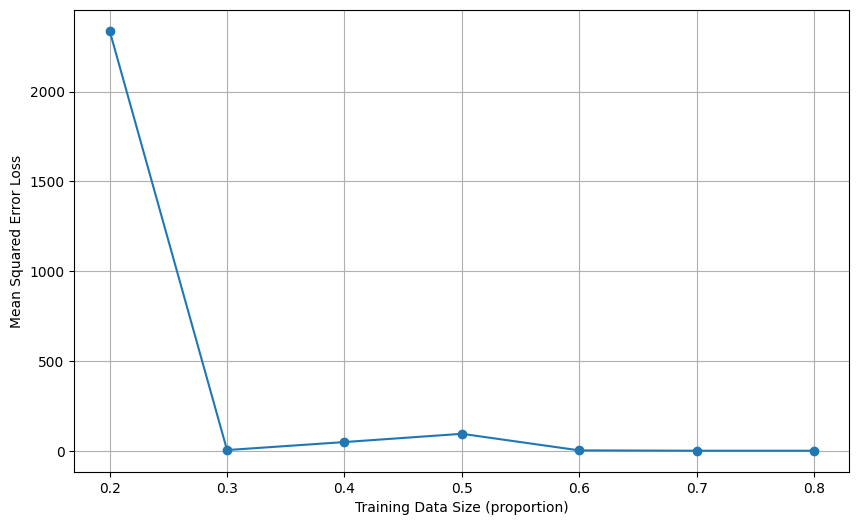

In [ ]:
def experiment_training_size_influence(X, y, model_selection, train_sizes):
    losses = []

    for size in train_sizes:
        X_train, _, y_train, _ = train_test_split(X, y, train_size=size, random_state=42)

        model = model_selection()

        if isinstance(model, LogisticRegressionModel):
            model.fit(X_train, y_train)
            w = np.concatenate([model.coefficients, [model.intercept]])
            loss = cost_fn(X_train, y_train, w)
        else:
            model.fit(X_train, y_train)
            model = LinearRegressionModel()
            loss, _ = model.fit(X_train, y_train)

        losses.append(loss)

    return losses

train_sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Linear Regression Model
losses = experiment_training_size_influence(X_train, y_train, LinearRegressionModel, train_sizes)

print("Impact of Training Data Size on Linear Regression Model Performance")
for size, loss in zip(train_sizes, losses):
    print(f"Training size: {size:.1f}, Loss: {loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, losses, marker='o')
plt.xlabel('Training Data Size (proportion)')
plt.ylabel('Mean Squared Error Loss')
plt.grid(True)
plt.show()

# Logistic Regression Model
losses = experiment_training_size_influence(X2_train, y2_train, LogisticRegressionModel, train_sizes)

print("\nImpact of Training Data Size on Logistic Regression Model Performance")
for size, loss in zip(train_sizes, losses):
    print(f"Training size: {size:.1f}, Loss: {loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, losses, marker='o')
plt.xlabel('Training Data Size (proportion)')
plt.ylabel('Mean Squared Error Loss')
plt.grid(True)
plt.show()

## Experiment 4: Try different mini-batch sizes

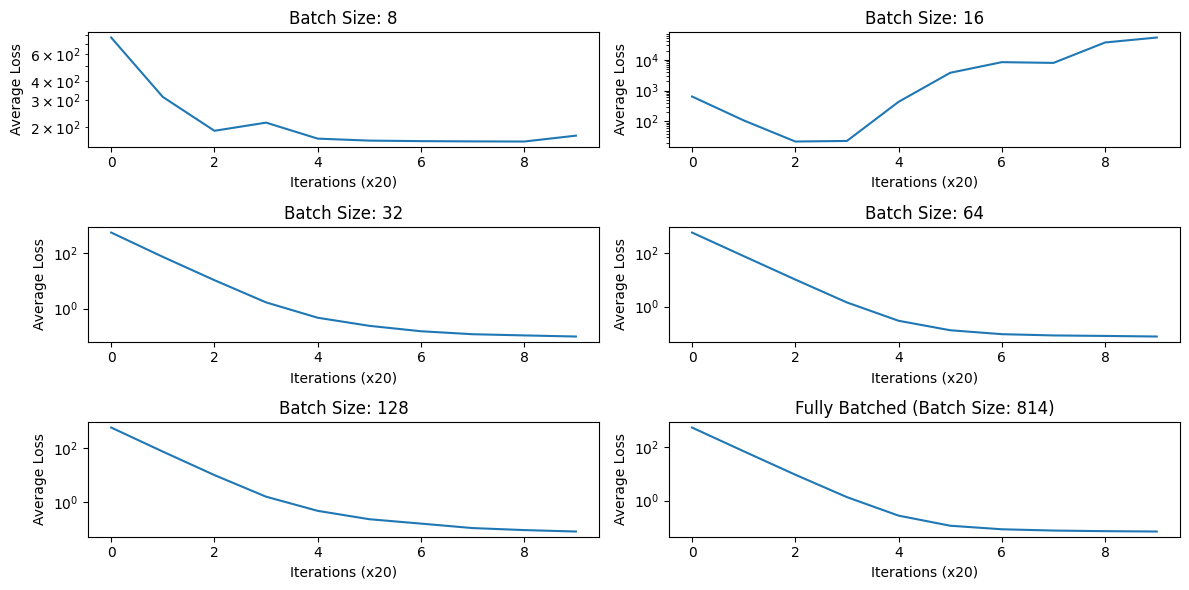

Summary of Mini-batch Size Influence on SGD Linear Regression Loss:
Batch size: 8
  Final loss: 165.700112
  Mean loss: 248.372446
  Min loss: 161.384243

Batch size: 16
  Final loss: 41225.610990
  Mean loss: 11115.222944
  Min loss: 9.079446

Batch size: 32
  Final loss: 0.093229
  Mean loss: 66.355727
  Min loss: 0.091383

Batch size: 64
  Final loss: 0.074965
  Mean loss: 65.485548
  Min loss: 0.074802

Batch size: 128
  Final loss: 0.077035
  Mean loss: 64.643309
  Min loss: 0.077035

Batch size: 814
  Final loss: 0.068715
  Mean loss: 63.519177
  Min loss: 0.068715



In [ ]:
def minibatch_iteration(X, y, max_iters=200):
    N = X.shape[0]
    batch_size = 2**3
    loss_histories = []

    # Mini-batch iterations
    for _ in range(5):
        model = LinearRegressionSGD()
        losses = []
        for iteration in range(max_iters):
            model.fit(X, y, max_iterations=1, learning_rate=5e-2, batch_size=batch_size)
            _, loss = model.linear_loss(np.column_stack([np.ones(N), X]), y)
            losses.append(loss)
        loss_histories.append(losses)
        batch_size *= 2

    # Fully batched baseline (batch_size = N)
    model_fully_batched = LinearRegressionSGD()
    full_batch_losses = []
    for iteration in range(max_iters):
        model_fully_batched.fit(X, y, max_iterations=1, learning_rate=5e-2, batch_size=N)
        _, loss = model_fully_batched.linear_loss(np.column_stack([np.ones(N), X]), y)
        full_batch_losses.append(loss)

    loss_histories.append(full_batch_losses)

    return loss_histories

# Running the experiment
loss_histories = minibatch_iteration(X_train, y_train)

# Adding the fully batched baseline
batch_sizes = [2**i for i in range(3, 8)] + [X_train.shape[0]]  # List of batch sizes + full batch

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
k = 0

for i in range(3):
    for j in range(2):
        if k < len(loss_histories):
            loss_history = np.array(loss_histories[k]).reshape(-1, 20).mean(1)
            axes[i, j].plot(loss_history)
            if batch_sizes[k] == X_train.shape[0]:
                title = f"Fully Batched (Batch Size: {batch_sizes[k]})"
            else:
                title = f"Batch Size: {batch_sizes[k]}"
            axes[i, j].set(xlabel="Iterations (x20)", ylabel="Average Loss",
                           title=title)
            axes[i, j].set_yscale('log')
            k += 1
        else:
            fig.delaxes(axes[i, j])

fig.tight_layout()
plt.show()

# Print summary statistics
print("Summary of Mini-batch Size Influence on SGD Linear Regression Loss:")
for batch_size, losses in zip(batch_sizes, loss_histories):
    print(f"Batch size: {batch_size}")
    print(f"  Final loss: {losses[-1]:.6f}")
    print(f"  Mean loss: {np.mean(losses):.6f}")
    print(f"  Min loss: {np.min(losses):.6f}")
    print()


## Experiment 5: Try different learning rates

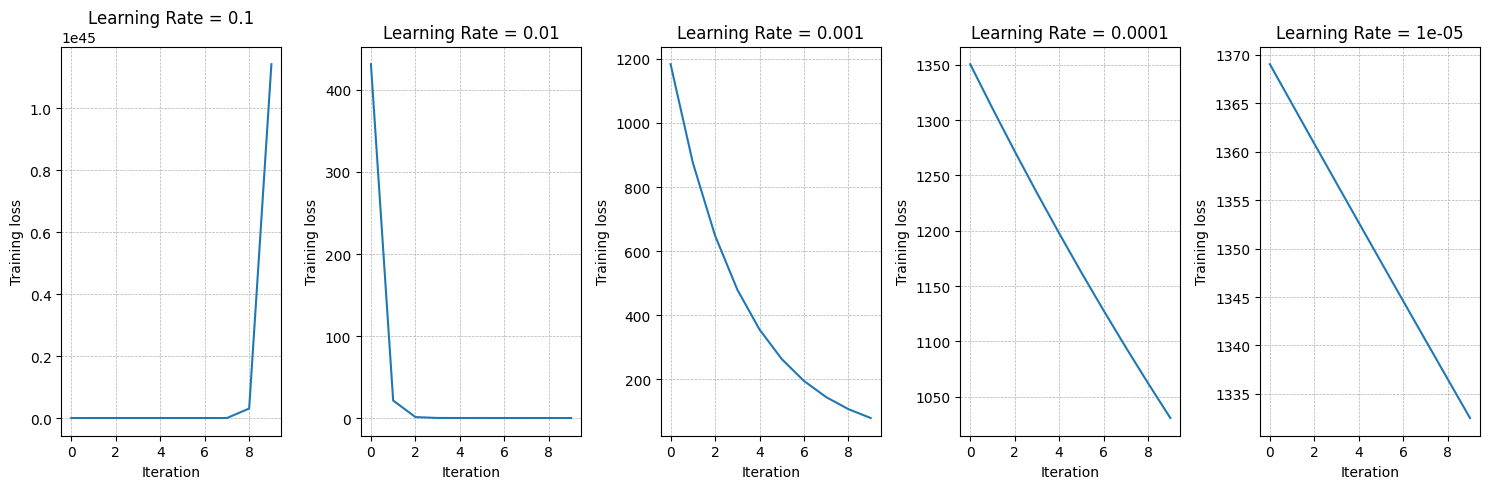


Summary of Learning Rate Influence on SGD Linear Regression Loss:

Learning Rate: 0.1
  Min loss: 6.778732
  Mean loss: 117222650119774130791639800693346536781774848.000000
  Final loss: 2673320663846335272045001035288839680373555200.000000

Learning Rate: 0.01
  Min loss: 0.067324
  Mean loss: 45.459295
  Final loss: 0.067445

Learning Rate: 0.001
  Min loss: 68.343945
  Mean loss: 433.362372
  Final loss: 68.343945

Learning Rate: 0.0001
  Min loss: 1015.227663
  Mean loss: 1184.225382
  Final loss: 1015.227663

Learning Rate: 1e-05
  Min loss: 1330.519625
  Mean loss: 1350.702447
  Final loss: 1330.519625



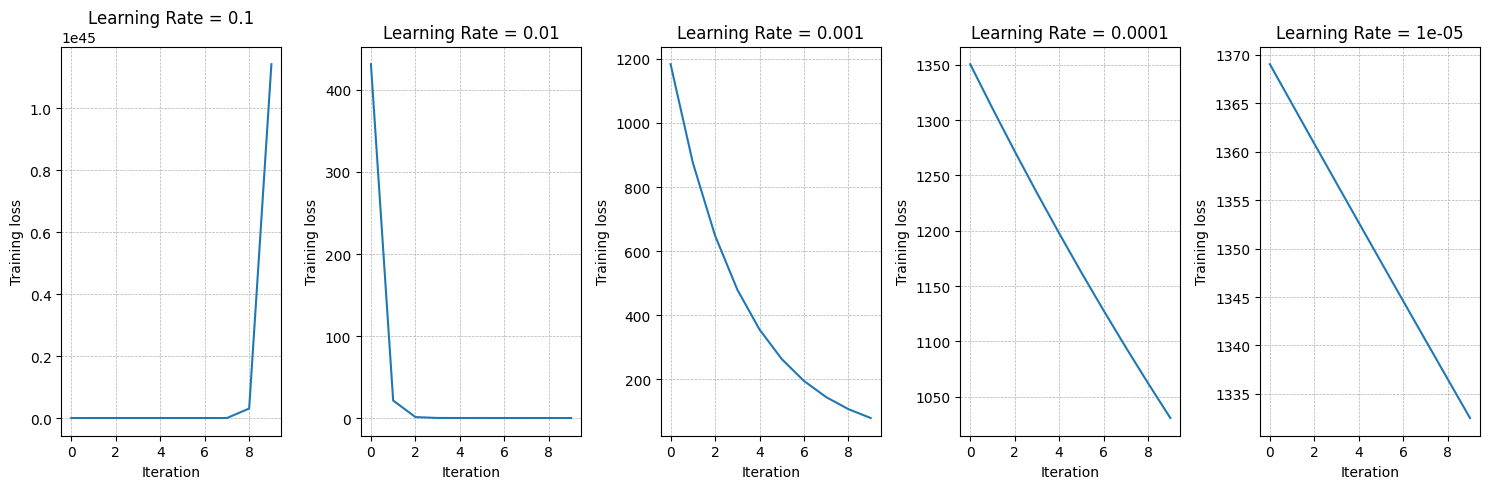


Summary of Learning Rate Influence on SGD Linear Regression Loss:

Learning Rate: 0.1
  Min loss: 6.778732
  Mean loss: 117222650119774130791639800693346536781774848.000000
  Final loss: 2673320663846335272045001035288839680373555200.000000

Learning Rate: 0.01
  Min loss: 0.067324
  Mean loss: 45.459295
  Final loss: 0.067445

Learning Rate: 0.001
  Min loss: 68.343945
  Mean loss: 433.362372
  Final loss: 68.343945

Learning Rate: 0.0001
  Min loss: 1015.227663
  Mean loss: 1184.225382
  Final loss: 1015.227663

Learning Rate: 1e-05
  Min loss: 1330.519625
  Mean loss: 1350.702447
  Final loss: 1330.519625



In [ ]:
def learning_rate_experiment(X, y, learning_rates, max_iters=200, batch_size=32):
    loss_histories = []

    for lr in learning_rates:
        model = LinearRegressionSGD()
        losses = []

        for iteration in range(max_iters):
            model.fit(X, y, max_iterations=1, learning_rate=lr, batch_size=batch_size)
            _, loss = model.linear_loss(np.column_stack([np.ones(X.shape[0]), X]), y)
            losses.append(loss)

        loss_histories.append(losses)

    return loss_histories

# Experiment parameters
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
max_iterations = 1500
batch_size = 32

# Run the experiment
loss_histories = learning_rate_experiment(X_train, y_train, learning_rates, max_iterations, batch_size)

# Plotting
fig, axs = plt.subplots(1, len(learning_rates), figsize=(15, 5))

for i, learning_rate in enumerate(learning_rates):
    loss_history = loss_histories[i]
    axs[i].plot(np.array(loss_history).reshape(-1, 150).mean(1))
    axs[i].set_title(f"Learning Rate = {learning_rate}")
    axs[i].set_xlabel("Iteration")
    axs[i].set_ylabel("Training loss")
    axs[i].grid(linestyle='--', linewidth=0.5)

fig.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Learning Rate Influence on SGD Linear Regression Loss:\n")
for lr, losses in zip(learning_rates, loss_histories):
    print(f"Learning Rate: {lr}")
    print(f"  Min loss: {np.min(losses):.6f}")
    print(f"  Mean loss: {np.mean(losses):.6f}")
    print(f"  Final loss: {losses[-1]:.6f}\n")

# Logistic Regression
class LogisticRegressionModel:
    def __init__(self, learning_rate=0.01, num_iterations=1000, batch_size=32):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.coefficients = None
        self.intercept = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        self.coefficients = np.zeros(n)
        self.intercept = 0

        for iteration in range(self.num_iterations):
            for i in range(0, m, self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]

                z = X_batch.dot(self.coefficients) + self.intercept
                h = self.sigmoid(z)
                gradient_w = (1 / len(X_batch)) * X_batch.T.dot(h - y_batch)
                gradient_b = (1 / len(X_batch)) * np.sum(h - y_batch)

                # Update weights and bias
                self.coefficients -= self.learning_rate * gradient_w
                self.intercept -= self.learning_rate * gradient_b

            # Calculate and store the loss at each iteration
            z = X.dot(self.coefficients) + self.intercept
            h = self.sigmoid(z)
            loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
            self.loss_history.append(loss)

            # Optionally print the loss every 100 iterations
            if iteration % 100 == 0:
                print(f"Iteration {iteration}: Loss = {loss}")

    def predict(self, X):
        z = X.dot(self.coefficients) + self.intercept
        return (self.sigmoid(z) >= 0.5).astype(int)

# Experiment parameters
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
max_iterations = 1500
batch_size = 32

# Run the logistic regression experiment
log_loss_histories = LogisticRegressionModel()

# Plotting
fig, axs = plt.subplots(1, len(learning_rates), figsize=(15, 5))

for i, learning_rate in enumerate(learning_rates):
    loss_history = loss_histories[i]
    axs[i].plot(np.array(loss_history).reshape(-1, 150).mean(1))
    axs[i].set_title(f"Learning Rate = {learning_rate}")
    axs[i].set_xlabel("Iteration")
    axs[i].set_ylabel("Training loss")
    axs[i].grid(linestyle='--', linewidth=0.5)

fig.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Learning Rate Influence on SGD Linear Regression Loss:\n")
for lr, losses in zip(learning_rates, loss_histories):
    print(f"Learning Rate: {lr}")
    print(f"  Min loss: {np.min(losses):.6f}")
    print(f"  Mean loss: {np.mean(losses):.6f}")
    print(f"  Final loss: {losses[-1]:.6f}\n")

## Experiment 6: Perform cross-validation using different learning rates

In [19]:
def cross_validation_experiment(X_train, y_train, X_test, y_test):
    num_folds = 5
    X_train_folds = np.array_split(X_train, num_folds)
    y_train_folds = np.array_split(y_train, num_folds)
    results = {}
    best_val = np.inf
    best_lr = None
    best_model = None
    learning_rates = np.linspace(1e-2, 1e-5, 20)

    for lr in learning_rates:
        val_mse_avg = 0
        for i in range(num_folds):
            X_train_temp = np.concatenate([X_train_folds[j] for j in range(num_folds) if j != i])
            y_train_temp = np.concatenate([y_train_folds[j] for j in range(num_folds) if j != i])

            model = LinearRegressionSGD()
            model.fit(X_train_temp, y_train_temp, max_iterations=500, learning_rate=lr, verbose=False)

            y_train_pred = model.predict(X_train_temp)
            y_val_pred = model.predict(X_train_folds[i])
            y_test_pred = model.predict(X_test)

            train_mse = np.mean((y_train_temp - y_train_pred) ** 2)
            val_mse = np.mean((y_train_folds[i] - y_val_pred) ** 2)
            test_mse = np.mean((y_test - y_test_pred) ** 2)

            results[(lr, i)] = (train_mse, val_mse, test_mse)
            val_mse_avg += val_mse

        val_mse_avg /= num_folds
        if val_mse_avg < best_val:
            best_val = val_mse_avg
            best_lr = lr
            best_model = model

    # Print out results
    for lr, i in sorted(results):
        train_mse, val_mse, test_mse = results[(lr, i)]
        print(f'lr {lr:.6e} train MSE: {train_mse:.6f} val MSE: {val_mse:.6f} test MSE: {test_mse:.6f}')

    print(f'Best average validation mean squared error achieved during cross-validation: {best_val:.6f}, with learning rate {best_lr:.6e}')

    return best_model, best_lr

# Assuming X_train, y_train, X_test, y_test are your data
best_model, best_lr = cross_validation_experiment(X_train, y_train, X_test, y_test)

# Use the best model to make predictions on the test set
y_test_pred = best_model.predict(X_test)
final_test_mse = np.mean((y_test - y_test_pred) ** 2)
print(f'Final Test MSE with best model: {final_test_mse:.6f}')

# Logistic Regression
def cross_validation_experiment_logistic(X_train, y_train, X_test, y_test):
    num_folds = 5
    X_train_folds = np.array_split(X_train, num_folds)
    y_train_folds = np.array_split(y_train, num_folds)
    results = {}
    best_val = 0
    best_lr = None
    best_model = None
    learning_rates = np.linspace(1e-2, 1e-5, 20)

    for lr in learning_rates:
        val_accuracy_avg = 0
        for i in range(num_folds):
            X_train_temp = np.concatenate([X_train_folds[j] for j in range(num_folds) if j != i])
            y_train_temp = np.concatenate([y_train_folds[j] for j in range(num_folds) if j != i])
            X_train_temp_small, _, y_train_temp_small, _ = train_test_split(X_train_temp, y_train_temp, train_size=0.1, random_state=42)

            model = LogisticRegressionModel()
            model.fit(X_train_temp_small, y_train_temp_small)

            y_train_pred = model.predict(X_train_temp)
            y_val_pred = model.predict(X_train_folds[i])
            y_test_pred = model.predict(X_test)

            # Calculate accuracy for each split
            train_accuracy = accuracy_score(y_train_temp, y_train_pred)
            val_accuracy = accuracy_score(y_train_folds[i], y_val_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)

            results[(lr, i)] = (train_accuracy, val_accuracy, test_accuracy)
            val_accuracy_avg += val_accuracy

        val_accuracy_avg /= num_folds
        if val_accuracy_avg > best_val:
            best_val = val_accuracy_avg
            best_lr = lr
            best_model = model

    for lr, i in sorted(results):
        train_accuracy, val_accuracy, test_accuracy = results[(lr, i)]
        print(f'lr {lr:.6e} train accuracy: {train_accuracy:.6f} val accuracy: {val_accuracy:.6f} test accuracy: {test_accuracy:.6f}')

    print(f'Best average validation accuracy achieved during cross-validation: {best_val:.6f}, with learning rate {best_lr:.6e}')

    return best_model, best_lr


best_model, best_lr = cross_validation_experiment_logistic(X2_train, y2_train, X2_test, y2_test)

y_test_pred = best_model.predict(X2_test)
final_test_accuracy = accuracy_score(y2_test, y2_test_pred)
print(f'Final Test Accuracy with best model: {final_test_accuracy:.6f}')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


lr 1.000000e-05 train MSE: 1356.617919 val MSE: 1361.372595 test MSE: 1358.946509
lr 1.000000e-05 train MSE: 1358.333161 val MSE: 1353.681293 test MSE: 1358.939740
lr 1.000000e-05 train MSE: 1357.984124 val MSE: 1355.710076 test MSE: 1358.305173
lr 1.000000e-05 train MSE: 1356.488098 val MSE: 1360.726945 test MSE: 1358.728621
lr 1.000000e-05 train MSE: 1356.813499 val MSE: 1359.941523 test MSE: 1358.313369
lr 5.357895e-04 train MSE: 799.794481 val MSE: 825.618905 test MSE: 815.971207
lr 5.357895e-04 train MSE: 800.902728 val MSE: 817.379434 test MSE: 808.713865
lr 5.357895e-04 train MSE: 799.596076 val MSE: 814.763707 test MSE: 805.574713
lr 5.357895e-04 train MSE: 800.107345 val MSE: 819.862304 test MSE: 809.534659
lr 5.357895e-04 train MSE: 796.906788 val MSE: 835.337408 test MSE: 810.153955
lr 1.061579e-03 train MSE: 471.190893 val MSE: 501.953978 test MSE: 485.091444
lr 1.061579e-03 train MSE: 471.917229 val MSE: 483.358616 test MSE: 486.052475
lr 1.061579e-03 train MSE: 472.701408

## Experiment 7: Compare analytical solution with mini-batch SGD


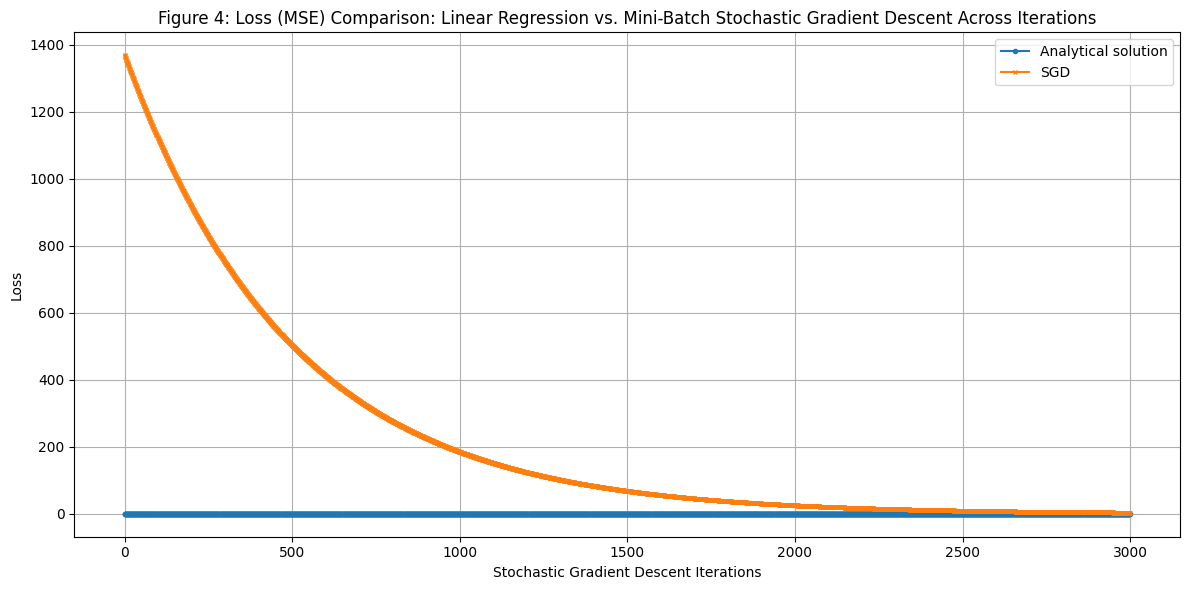

In [ ]:
def analytical_solution(X, y):
    X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
    weights = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
    return weights

def mse_loss(X, y, weights):
    X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
    predictions = X_with_bias @ weights
    return np.mean((y - predictions) ** 2)

def comparison_experiment(X, y, max_iterations=3000, batch_size=32, learning_rate=1e-3):
    # Analytical solution
    analytical_weights = analytical_solution(X, y)
    analytical_mse = mse_loss(X, y, analytical_weights)

    # Mini-batch SGD
    sgd_model = LinearRegressionSGD()
    sgd_losses = []

    for iteration in range(max_iterations):
        sgd_model.fit(X, y, max_iterations=1, learning_rate=learning_rate, batch_size=batch_size)
        sgd_mse = mse_loss(X, y, sgd_model.weights)
        sgd_losses.append(sgd_mse)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(max_iterations), [analytical_mse] * max_iterations, label='Analytical solution', marker='o', markersize=3)
    plt.plot(range(max_iterations), sgd_losses, label='SGD', marker='x', markersize=3)

    plt.xlabel('Stochastic Gradient Descent Iterations')
    plt.ylabel('Loss')
    plt.title('Figure 4: Loss (MSE) Comparison: Linear Regression vs. Mini-Batch Stochastic Gradient Descent Across Iterations')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Assuming X and y are your feature matrix and target vector
comparison_experiment(X_train, y_train)